463


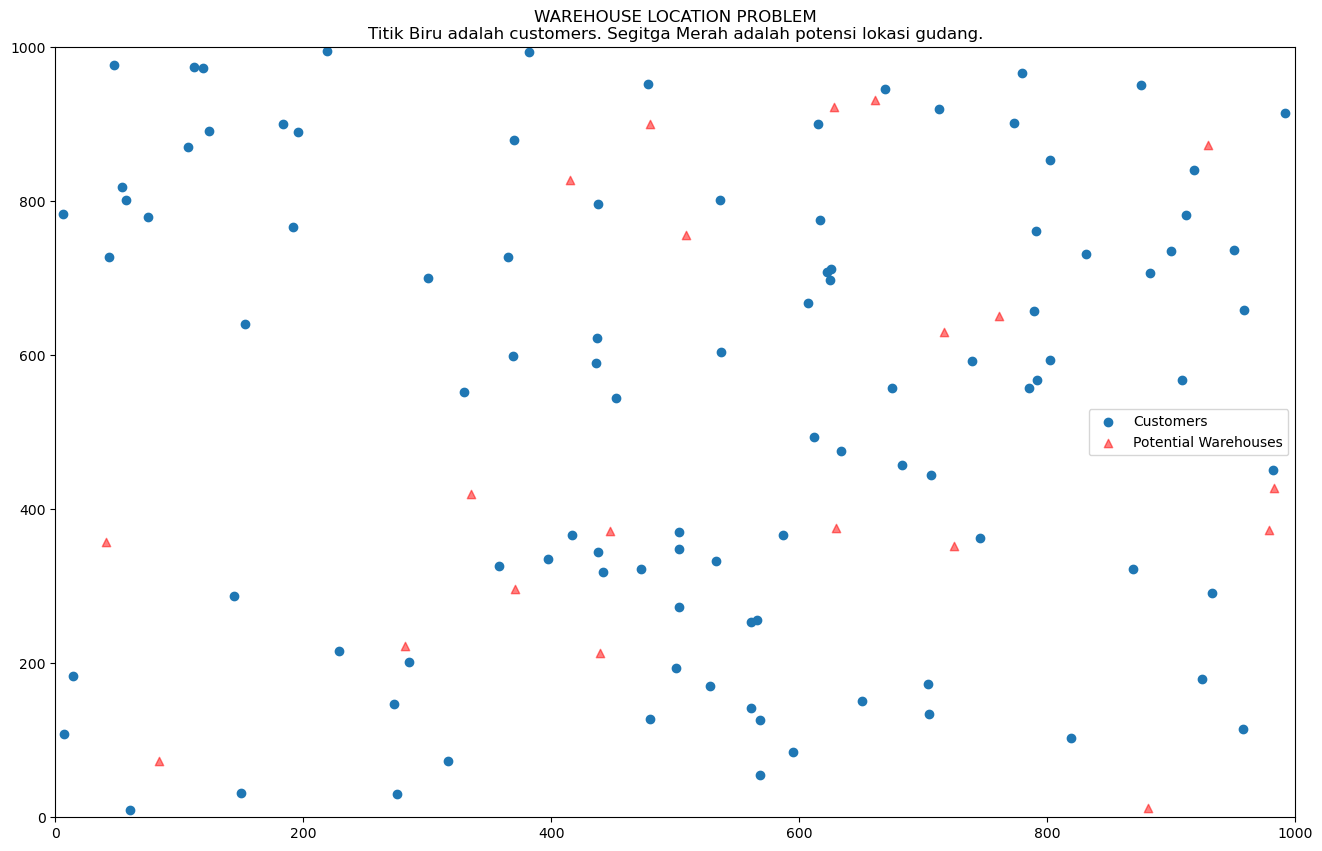

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from pulp import LpMinimize, LpProblem, LpVariable, lpSum, LpBinary

# Setting the seed
np.random.seed(1234)
grid_size = 1000
n = 100

# Generating customer locations
customer_locations = pd.DataFrame({
    'id': range(1, n+1),
    'x': np.round(np.random.uniform(0, grid_size, n)),
    'y': np.round(np.random.uniform(0, grid_size, n))
})

m = 20

# Generating warehouse locations
warehouse_locations = pd.DataFrame({
    'id': range(1, m+1),
    'x': np.round(np.random.uniform(0, grid_size, m)),
    'y': np.round(np.random.uniform(0, grid_size, m))
})

fixedcost = np.round(np.random.normal(loc=grid_size * 10, scale=grid_size * 5, size=m))

def transportcost(i, j):
    customer = customer_locations.iloc[i]
    warehouse = warehouse_locations.iloc[j]
    return round(math.sqrt((customer['x'] - warehouse['x'])**2 + (customer['y'] - warehouse['y'])**2))

# Example of transportcost function
print(transportcost(0, 2))

# Plotting the locations
plt.figure(figsize=(16, 10))
plt.scatter(customer_locations['x'], customer_locations['y'], label='Customers')
plt.scatter(warehouse_locations['x'], warehouse_locations['y'], color='red', alpha=0.5, marker='^', label='Potential Warehouses')
plt.xlim(0, grid_size)
plt.ylim(0, grid_size)
plt.title("WAREHOUSE LOCATION PROBLEM\nTitik Biru adalah customers. Segitga Merah adalah potensi lokasi gudang.")
plt.legend()
# Save the plot to a file
plt.savefig('plot gudang customer.png')  # You can change 'plot.png' to your desired file name and format
plt.show()


<Figure size 640x480 with 0 Axes>

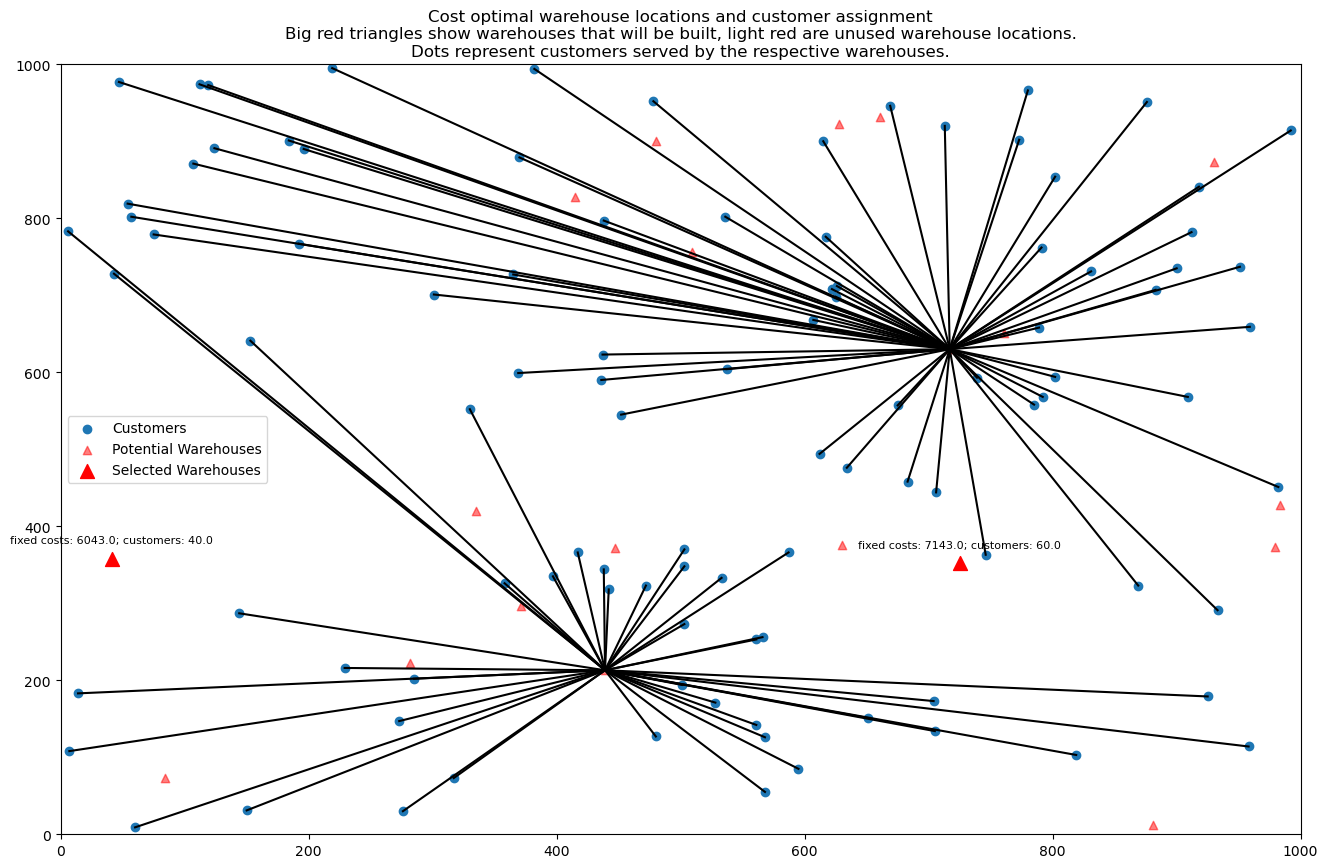

In [11]:
# Defining the optimization problem
model = LpProblem("Warehouse_Location_Problem", LpMinimize)

# Decision variables
x = LpVariable.dicts("x", ((i, j) for i in range(n) for j in range(m)), cat=LpBinary)
y = LpVariable.dicts("y", range(m), cat=LpBinary)

# Objective function
model += lpSum(transportcost(i, j) * x[i, j] for i in range(n) for j in range(m)) + lpSum(fixedcost[j] * y[j] for j in range(m))

# Constraints
for i in range(n):
    model += lpSum(x[i, j] for j in range(m)) == 1

for i in range(n):
    for j in range(m):
        model += x[i, j] <= y[j]

# Solving the problem
model.solve()

# Extracting the results
assignment = [(i, j) for i in range(n) for j in range(m) if x[i, j].varValue == 1]
customer_count = pd.DataFrame(assignment, columns=['customer', 'warehouse']).groupby('warehouse').size().reset_index(name='count')
plot_warehouses = pd.merge(warehouse_locations, customer_count, left_on='id', right_on='warehouse')
plot_warehouses = pd.merge(plot_warehouses, pd.DataFrame(fixedcost, columns=['cost']), left_on='id', right_index=True)

# Plotting the results
plt.figure(figsize=(16, 10))
plt.scatter(customer_locations['x'], customer_locations['y'], label='Customers')
plt.scatter(warehouse_locations['x'], warehouse_locations['y'], color='red', alpha=0.5, marker='^', label='Potential Warehouses')
for (i, j) in assignment:
    customer = customer_locations.iloc[i]
    warehouse = warehouse_locations.iloc[j]
    plt.plot([customer['x'], warehouse['x']], [customer['y'], warehouse['y']], 'k-')
plt.scatter(plot_warehouses['x'], plot_warehouses['y'], color='red', s=100, marker='^', label='Selected Warehouses')
for idx, row in plot_warehouses.iterrows():
    plt.text(row['x'], row['y'] + 20, f"fixed costs: {row['cost']}; customers: {row['count']}", fontsize=8, ha='center')
plt.xlim(0, grid_size)
plt.ylim(0, grid_size)
plt.title("Cost optimal warehouse locations and customer assignment\nBig red triangles show warehouses that will be built, light red are unused warehouse locations.\nDots represent customers served by the respective warehouses.")
plt.legend()
plt.show()

In [3]:
total_fixed_cost = sum(fixedcost)
print(f'The total fixed cost is: {total_fixed_cost}')


The total fixed cost is: 230312.0


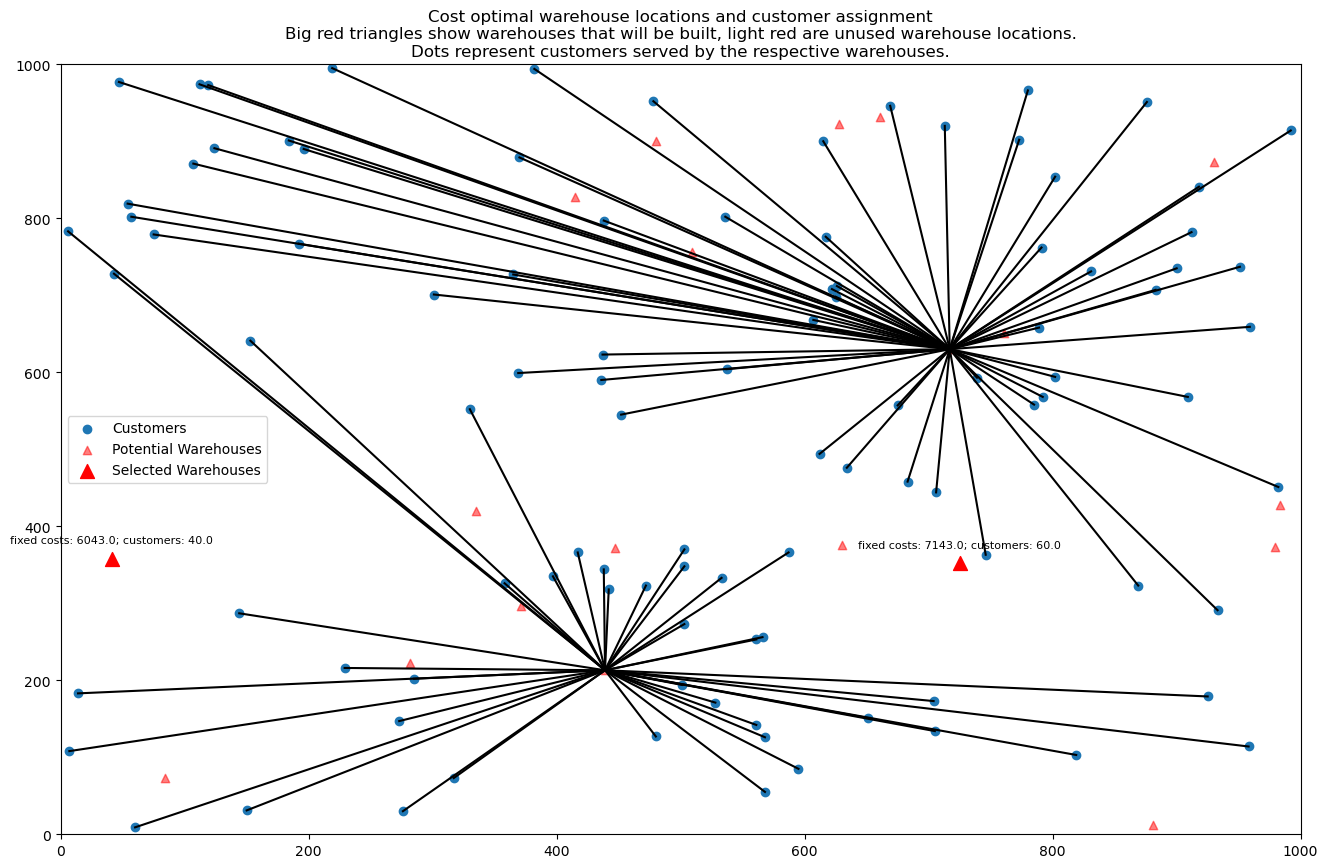

In [23]:
# Defining the optimization problem
model = LpProblem("Warehouse_Location_Problem", LpMinimize)

# Decision variables
x = LpVariable.dicts("x", ((i, j) for i in range(n) for j in range(m)), cat=LpBinary)
y = LpVariable.dicts("y", range(m), cat=LpBinary)

# Objective function
model += lpSum(transportcost(i, j) * x[i, j] for i in range(n) for j in range(m)) + lpSum(fixedcost[j] * y[j] for j in range(m))

# Constraints
for i in range(n):
    model += lpSum(x[i, j] for j in range(m)) == 1

for i in range(n):
    for j in range(m):
        model += x[i, j] <= y[j]

# New constraint: Exactly 3 or 4 warehouses must be built
model += lpSum(y[j] for j in range(m)) == 2  # Change this to 3 for exactly 3 warehouses

# Solving the problem
model.solve()

# Extracting the results
assignment = [(i, j) for i in range(n) for j in range(m) if x[i, j].varValue == 1]
customer_count = pd.DataFrame(assignment, columns=['customer', 'warehouse']).groupby('warehouse').size().reset_index(name='count')
plot_warehouses = pd.merge(warehouse_locations, customer_count, left_on='id', right_on='warehouse')
plot_warehouses = pd.merge(plot_warehouses, pd.DataFrame(fixedcost, columns=['cost']), left_on='id', right_index=True)

# Plotting the results
plt.figure(figsize=(16, 10))
plt.scatter(customer_locations['x'], customer_locations['y'], label='Customers')
plt.scatter(warehouse_locations['x'], warehouse_locations['y'], color='red', alpha=0.5, marker='^', label='Potential Warehouses')
for (i, j) in assignment:
    customer = customer_locations.iloc[i]
    warehouse = warehouse_locations.iloc[j]
    plt.plot([customer['x'], warehouse['x']], [customer['y'], warehouse['y']], 'k-')
plt.scatter(plot_warehouses['x'], plot_warehouses['y'], color='red', s=100, marker='^', label='Selected Warehouses')
for idx, row in plot_warehouses.iterrows():
    plt.text(row['x'], row['y'] + 20, f"fixed costs: {row['cost']}; customers: {row['count']}", fontsize=8, ha='center')
plt.xlim(0, grid_size)
plt.ylim(0, grid_size)
plt.title("Cost optimal warehouse locations and customer assignment\nBig red triangles show warehouses that will be built, light red are unused warehouse locations.\nDots represent customers served by the respective warehouses.")
plt.legend()
plt.show()


In [33]:
# Defining the optimization problem
model = LpProblem("Warehouse_Location_Problem", LpMinimize)

# Decision variables
x = LpVariable.dicts("x", ((i, j) for i in range(n) for j in range(m)), cat=LpBinary)
y = LpVariable.dicts("y", range(m), cat=LpBinary)

# Objective function
model += lpSum(transportcost(i, j) * x[i, j] for i in range(n) for j in range(m)) + lpSum(fixedcost[j] * y[j] for j in range(m))

# Constraints
for i in range(n):
    model += lpSum(x[i, j] for j in range(m)) == 1

for i in range(n):
    for j in range(m):
        model += x[i, j] <= y[j]

# New constraint: Budget limit
budget_limit = 100000  # Example budget limit
model += lpSum(fixedcost[j] * y[j] for j in range(m)) <= budget_limit

# Solving the problem
model.solve()


1

In [45]:
# Menampilkan pusat distribusi yang dipilih
selected_warehouses = [j for j in range(m) if y[j].varValue == 1]
print("Pusat Distribusi yang Dipilih:", selected_warehouses)

# Menampilkan alokasi pelanggan
customer_allocation = [(i, j) for i in range(n) for j in range(m) if x[i, j].varValue == 1]
print("Alokasi Pelanggan:", customer_allocation)

# Total biaya tetap
total_fixed_cost = sum(fixedcost[j] for j in selected_warehouses)
print(f'Total Biaya Tetap: {total_fixed_cost}')

# Plot visual
plt.figure(figsize=(16, 10))
plt.scatter(customer_locations['x'], customer_locations['y'], label='Pelanggan')
plt.scatter(warehouse_locations['x'], warehouse_locations['y'], color='red', alpha=0.5, marker='^', label='Pusat Distribusi')
for (i, j) in customer_allocation:
    customer = customer_locations.iloc[i]
    warehouse = warehouse_locations.iloc[j]
    plt.plot([customer['x'], warehouse['x']], [customer['y'], warehouse['y']], 'k-')
plt.scatter(warehouse_locations.loc[selected_warehouses, 'x'], warehouse_locations.loc[selected_warehouses, 'y'], 
            color='red', s=100, marker='^', label='Pusat Distribusi Terpilih')
plt.xlim(0, grid_size)
plt.ylim(0, grid_size)
plt.title("Lokasi Optimal Pusat Distribusi dan Alokasi Pelanggan\nSegitiga merah besar menunjukkan pusat 
distribusi yang dibangun, merah muda adalah lokasi pusat distribusi yang tidak digunakan.\nTitik-titik mewakili 
pelanggan yang dilayani oleh pusat distribusi masing-masing.")
plt.legend()
plt.show()


SyntaxError: unterminated string literal (detected at line 25) (4173714973.py, line 25)

In [41]:
from pulp import LpMinimize, LpProblem, LpVariable, lpSum, LpBinary

# Definisikan model optimasi
model = LpProblem("Warehouse_Location_Problem", LpMinimize)

# Variabel keputusan
x = LpVariable.dicts("x", ((i, j) for i in range(n) for j in range(m)), cat=LpBinary)
y = LpVariable.dicts("y", range(m), cat=LpBinary)

# Fungsi objektif
model += lpSum(transportcost(i, j) * x[i, j] for i in range(n) for j in range(m)) + lpSum(fixedcost[j] * y[j] for j in range(m))

# Kendala
for i in range(n):
    model += lpSum(x[i, j] for j in range(m)) == 1

for i in range(n):
    for j in range(m):
        model += x[i, j] <= y[j]

# Memecahkan masalah menggunakan solver GLPK
model.solve()

# Menampilkan hasil
print(f"Status: {model.status}, Value: {model.objective.value()}")


Status: 1, Value: 42798.0


In [43]:
import numpy as np
import pandas as pd

# Menetapkan seed
np.random.seed(1234)
grid_size = 1000
n = 100

# Menghasilkan lokasi pelanggan
customer_locations = pd.DataFrame({
    'id': range(1, n+1),
    'x': np.round(np.random.uniform(0, grid_size, n)),
    'y': np.round(np.random.uniform(0, grid_size, n))
})

m = 20

# Menghasilkan lokasi gudang
warehouse_locations = pd.DataFrame({
    'id': range(1, m+1),
    'x': np.round(np.random.uniform(0, grid_size, m)),
    'y': np.round(np.random.uniform(0, grid_size, m))
})

fixedcost = np.round(np.random.normal(loc=grid_size * 10, scale=grid_size * 5, size=m))

In [ ]:
def transportcost(i, j):
    customer = customer_locations.iloc[i]
    warehouse = warehouse_locations.iloc[j]
    return round(math.sqrt((customer['x'] - warehouse['x'])**2 + (customer['y'] - warehouse['y'])**2))


In [ ]:
# Plotting the locations
plt.figure(figsize=(16, 10))
plt.scatter(customer_locations['x'], customer_locations['y'], label='Customers')
plt.scatter(warehouse_locations['x'], warehouse_locations['y'], color='red', alpha=0.5, marker='^', label='Potential Warehouses')
plt.xlim(0, grid_size)
plt.ylim(0, grid_size)
plt.title("WAREHOUSE LOCATION PROBLEM\nTitik Biru adalah customers. Segitga Merah adalah potensi lokasi gudang.")
plt.legend()
# Save the plot to a file
plt.savefig('plot gudang customer.png')  # You can change 'plot.png' to your desired file name and format
plt.show()

Pusat Distribusi yang Dipilih: [5, 7]
Alokasi Pelanggan: [(0, 5), (1, 5), (2, 5), (3, 5), (4, 5), (5, 7), (6, 7), (7, 5), (8, 7), (9, 5), (10, 7), (11, 7), (12, 5), (13, 5), (14, 5), (15, 7), (16, 7), (17, 7), (18, 5), (19, 5), (20, 5), (21, 5), (22, 5), (23, 5), (24, 5), (25, 7), (26, 7), (27, 5), (28, 7), (29, 7), (30, 5), (31, 5), (32, 5), (33, 7), (34, 7), (35, 7), (36, 5), (37, 7), (38, 7), (39, 5), (40, 7), (41, 5), (42, 5), (43, 5), (44, 7), (45, 7), (46, 7), (47, 7), (48, 7), (49, 7), (50, 5), (51, 5), (52, 7), (53, 7), (54, 5), (55, 5), (56, 5), (57, 5), (58, 5), (59, 5), (60, 7), (61, 5), (62, 5), (63, 5), (64, 5), (65, 5), (66, 5), (67, 5), (68, 5), (69, 5), (70, 5), (71, 7), (72, 7), (73, 5), (74, 7), (75, 5), (76, 7), (77, 5), (78, 7), (79, 5), (80, 5), (81, 5), (82, 5), (83, 5), (84, 5), (85, 7), (86, 5), (87, 5), (88, 5), (89, 7), (90, 7), (91, 7), (92, 7), (93, 5), (94, 7), (95, 7), (96, 5), (97, 7), (98, 5), (99, 5)]
Jumlah Pelanggan per Pusat Distribusi:
   warehouse 

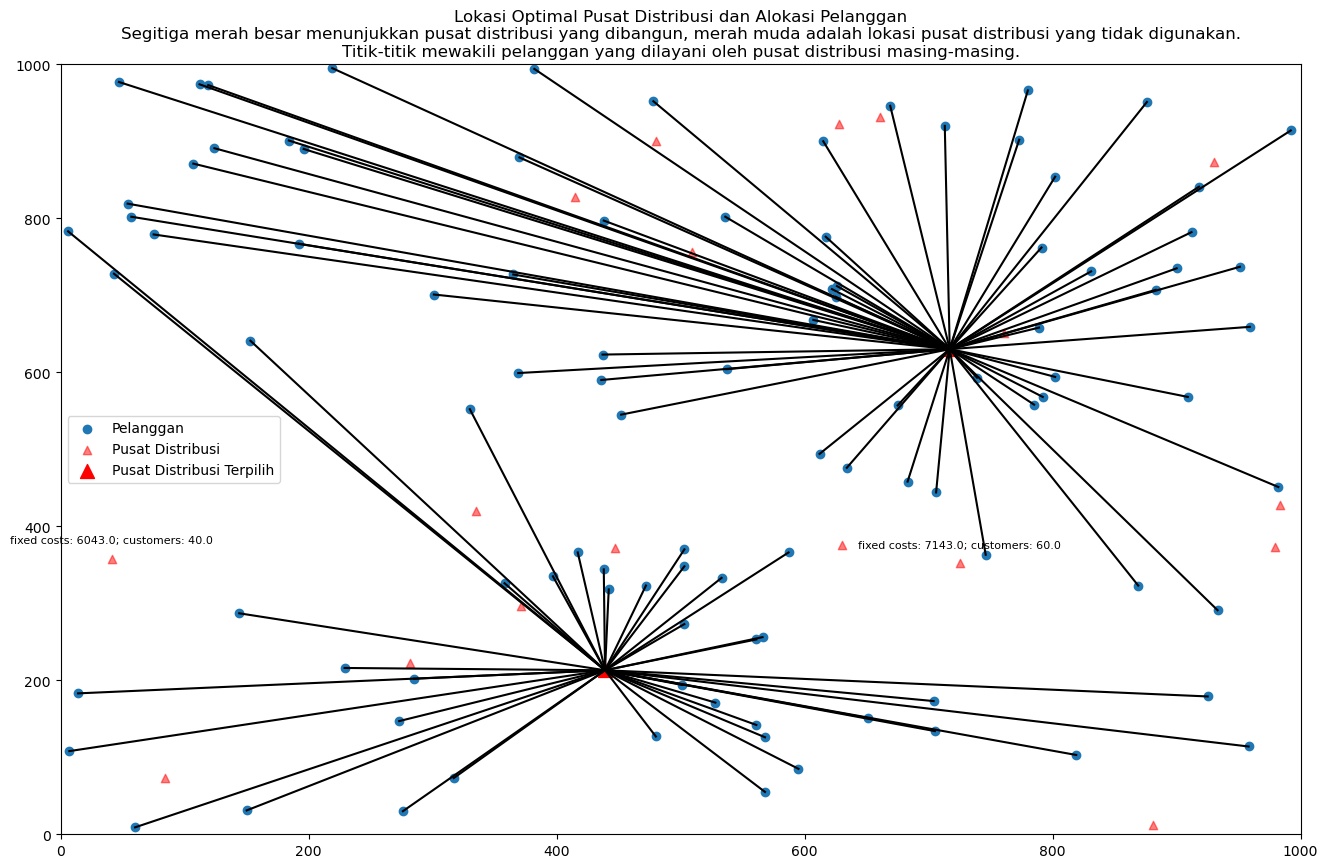

In [39]:
import matplotlib.pyplot as plt
import pandas as pd

# Menampilkan pusat distribusi yang dipilih
selected_warehouses = [j for j in range(m) if y[j].varValue == 1]
print("Pusat Distribusi yang Dipilih:", selected_warehouses)

# Menampilkan alokasi pelanggan
customer_allocation = [(i, j) for i in range(n) for j in range(m) if x[i, j].varValue == 1]
print("Alokasi Pelanggan:", customer_allocation)

# Menghitung jumlah pelanggan per pusat distribusi
customer_count = pd.DataFrame(customer_allocation, columns=['customer', 'warehouse']).groupby('warehouse').size().reset_index(name='count')
print("Jumlah Pelanggan per Pusat Distribusi:")
print(customer_count)

# Total biaya tetap
total_fixed_cost = sum(fixedcost[j] for j in selected_warehouses)
print(f'Total Biaya Tetap: {total_fixed_cost}')

# Plot visual
plt.figure(figsize=(16, 10))
plt.scatter(customer_locations['x'], customer_locations['y'], label='Pelanggan')
plt.scatter(warehouse_locations['x'], warehouse_locations['y'], color='red', alpha=0.5, marker='^', label='Pusat Distribusi')
for (i, j) in customer_allocation:
    customer = customer_locations.iloc[i]
    warehouse = warehouse_locations.iloc[j]
    plt.plot([customer['x'], warehouse['x']], [customer['y'], warehouse['y']], 'k-')
plt.scatter(warehouse_locations.loc[selected_warehouses, 'x'], warehouse_locations.loc[selected_warehouses, 'y'], 
            color='red', s=100, marker='^', label='Pusat Distribusi Terpilih')
for idx, row in plot_warehouses.iterrows():
    plt.text(row['x'], row['y'] + 20, f"fixed costs: {row['cost']}; customers: {row['count']}", fontsize=8, ha='center')
plt.xlim(0, grid_size)
plt.ylim(0, grid_size)
plt.title("Lokasi Optimal Pusat Distribusi dan Alokasi Pelanggan")
plt.legend()
plt.show()


Pusat Distribusi yang Dipilih: [5, 7]
Alokasi Pelanggan: [(0, 5), (1, 5), (2, 5), (3, 5), (4, 5), (5, 7), (6, 7), (7, 5), (8, 7), (9, 5), (10, 7), (11, 7), (12, 5), (13, 5), (14, 5), (15, 7), (16, 7), (17, 7), (18, 5), (19, 5), (20, 5), (21, 5), (22, 5), (23, 5), (24, 5), (25, 7), (26, 7), (27, 5), (28, 7), (29, 7), (30, 5), (31, 5), (32, 5), (33, 7), (34, 7), (35, 7), (36, 5), (37, 7), (38, 7), (39, 5), (40, 7), (41, 5), (42, 5), (43, 5), (44, 7), (45, 7), (46, 7), (47, 7), (48, 7), (49, 7), (50, 5), (51, 5), (52, 7), (53, 7), (54, 5), (55, 5), (56, 5), (57, 5), (58, 5), (59, 5), (60, 7), (61, 5), (62, 5), (63, 5), (64, 5), (65, 5), (66, 5), (67, 5), (68, 5), (69, 5), (70, 5), (71, 7), (72, 7), (73, 5), (74, 7), (75, 5), (76, 7), (77, 5), (78, 7), (79, 5), (80, 5), (81, 5), (82, 5), (83, 5), (84, 5), (85, 7), (86, 5), (87, 5), (88, 5), (89, 7), (90, 7), (91, 7), (92, 7), (93, 5), (94, 7), (95, 7), (96, 5), (97, 7), (98, 5), (99, 5)]
Jumlah Pelanggan per Pusat Distribusi:
   warehouse 

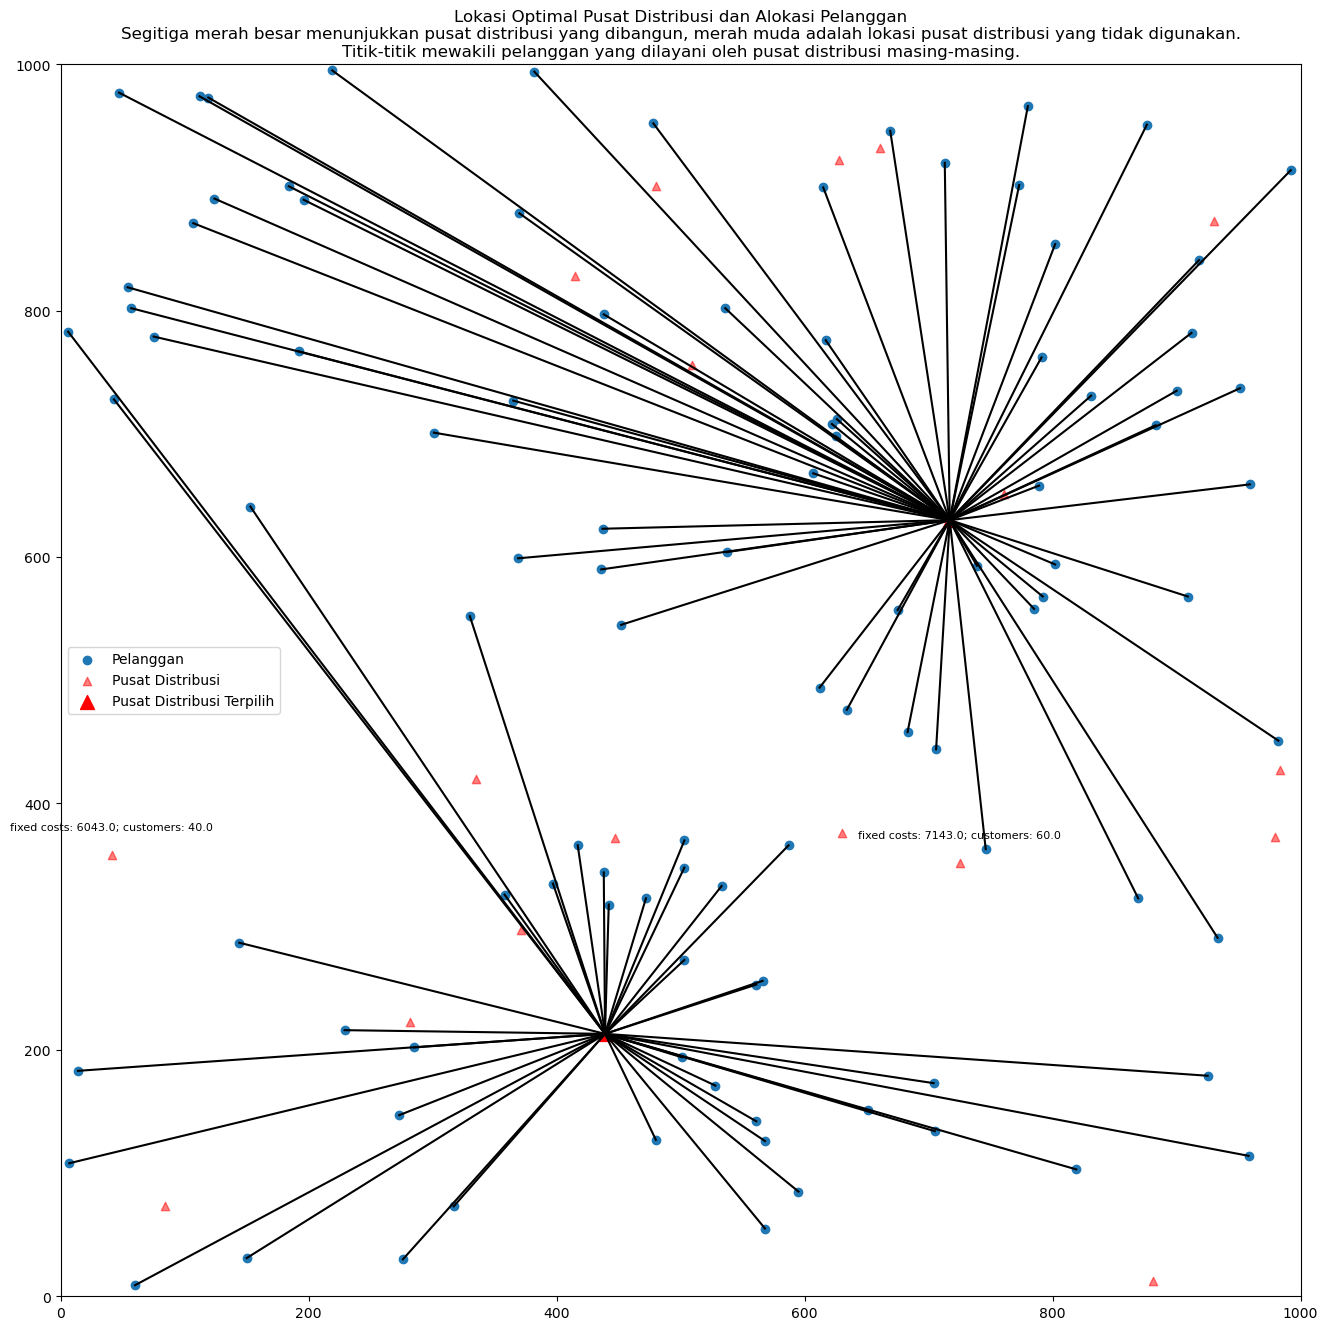

In [49]:
import matplotlib.pyplot as plt
import pandas as pd

# Menampilkan pusat distribusi yang dipilih
selected_warehouses = [j for j in range(m) if y[j].varValue == 1]
print("Pusat Distribusi yang Dipilih:", selected_warehouses)

# Menampilkan alokasi pelanggan
customer_allocation = [(i, j) for i in range(n) for j in range(m) if x[i, j].varValue == 1]
print("Alokasi Pelanggan:", customer_allocation)

# Menghitung jumlah pelanggan per pusat distribusi
customer_count = pd.DataFrame(customer_allocation, columns=['customer', 'warehouse']).groupby('warehouse').size().reset_index(name='count')
print("Jumlah Pelanggan per Pusat Distribusi:")
print(customer_count)

# Total biaya tetap
total_fixed_cost = sum(fixedcost[j] for j in selected_warehouses)
print(f'Total Biaya Tetap: {total_fixed_cost}')

# Plot visual
plt.figure(figsize=(16, 16))
plt.scatter(customer_locations['x'], customer_locations['y'], label='Pelanggan')
plt.scatter(warehouse_locations['x'], warehouse_locations['y'], color='red', alpha=0.5, marker='^', label='Pusat Distribusi')
for (i, j) in customer_allocation:
    customer = customer_locations.iloc[i]
    warehouse = warehouse_locations.iloc[j]
    plt.plot([customer['x'], warehouse['x']], [customer['y'], warehouse['y']], 'k-')
plt.scatter(warehouse_locations.loc[selected_warehouses, 'x'], warehouse_locations.loc[selected_warehouses, 'y'], color='red', s=100, marker='^', label='Pusat Distribusi Terpilih')
for idx, row in plot_warehouses.iterrows():
    plt.text(row['x'], row['y'] + 20, f"fixed costs: {row['cost']}; customers: {row['count']}", fontsize=8, ha='center')
plt.xlim(0, grid_size)
plt.ylim(0, grid_size)
plt.title("Lokasi Optimal Pusat Distribusi dan Alokasi Pelanggan\nSegitiga merah besar menunjukkan pusat distribusi yang dibangun, merah muda adalah lokasi pusat distribusi yang tidak digunakan.\nTitik-titik mewakili pelanggan yang dilayani oleh pusat distribusi masing-masing.")
plt.legend()
plt.show()


In [51]:
# Defining the optimization problem
model = LpProblem("Warehouse_Location_Problem", LpMinimize)

# Decision variables
x = LpVariable.dicts("x", ((i, j) for i in range(n) for j in range(m)), cat=LpBinary)
y = LpVariable.dicts("y", range(m), cat=LpBinary)

# Objective function
model += lpSum(transportcost(i, j) * x[i, j] for i in range(n) for j in range(m)) + lpSum(fixedcost[j] * y[j] for j in range(m))

# Constraints
for i in range(n):
    model += lpSum(x[i, j] for j in range(m)) == 1

for i in range(n):
    for j in range(m):
        model += x[i, j] <= y[j]

# New constraint: Exactly 3 or 4 warehouses must be built
model += lpSum(y[j] for j in range(m)) == 4  # Change this to 3 for exactly 3 warehouses

# Solving the problem
model.solve()

# Extracting the results
assignment = [(i, j) for i in range(n) for j in range(m) if x[i, j].varValue == 1]
customer_count = pd.DataFrame(assignment, columns=['customer', 'warehouse']).groupby('warehouse').size().reset_index(name='count')
plot_warehouses = pd.merge(warehouse_locations, customer_count, left_on='id', right_on='warehouse')
plot_warehouses = pd.merge(plot_warehouses, pd.DataFrame(fixedcost, columns=['cost']), left_on='id', right_index=True)

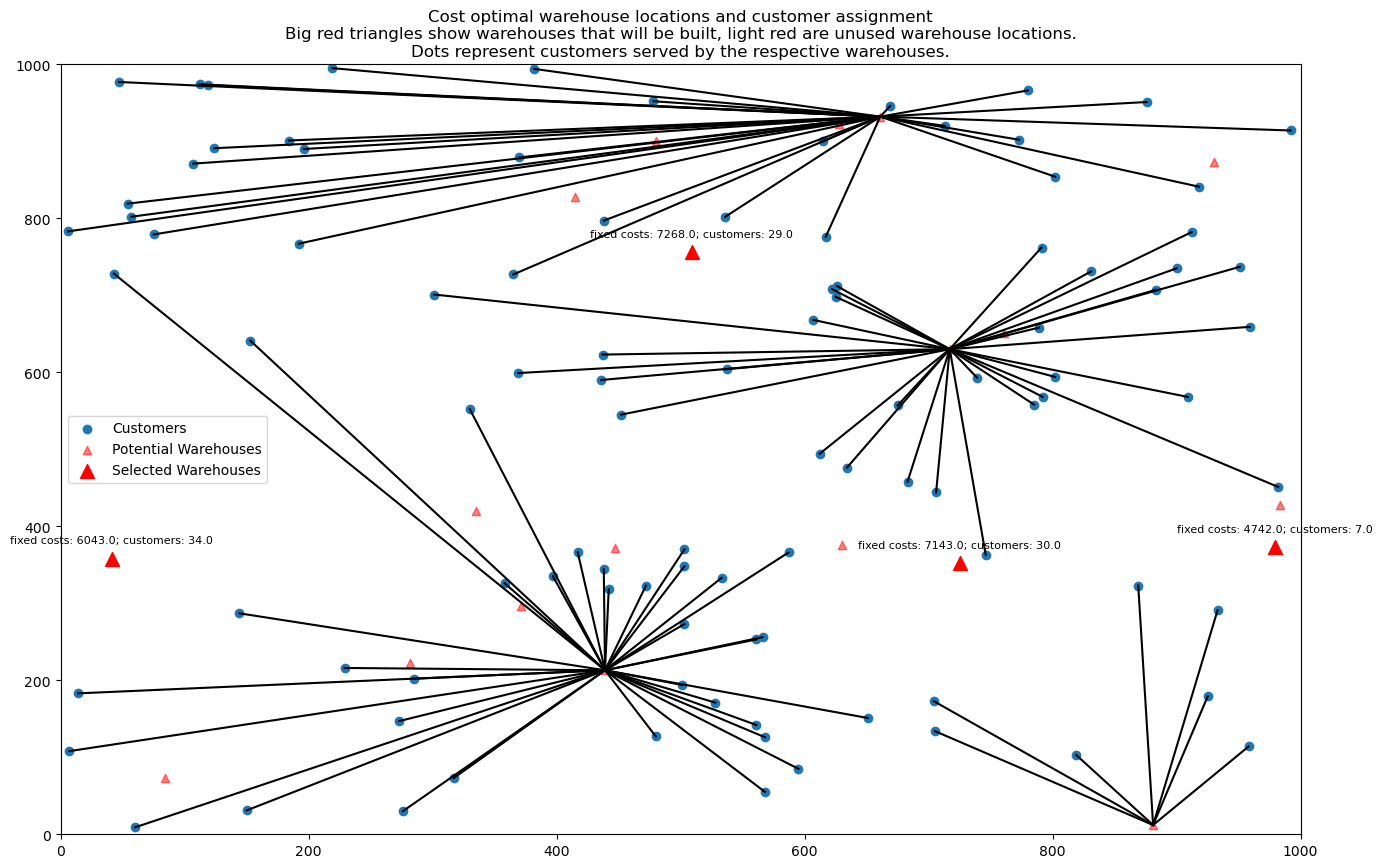

In [53]:
# Plotting the results
plt.figure(figsize=(16, 10))
plt.scatter(customer_locations['x'], customer_locations['y'], label='Customers')
plt.scatter(warehouse_locations['x'], warehouse_locations['y'], color='red', alpha=0.5, marker='^', label='Potential Warehouses')
for (i, j) in assignment:
    customer = customer_locations.iloc[i]
    warehouse = warehouse_locations.iloc[j]
    plt.plot([customer['x'], warehouse['x']], [customer['y'], warehouse['y']], 'k-')
plt.scatter(plot_warehouses['x'], plot_warehouses['y'], color='red', s=100, marker='^', label='Selected Warehouses')
for idx, row in plot_warehouses.iterrows():
    plt.text(row['x'], row['y'] + 20, f"fixed costs: {row['cost']}; customers: {row['count']}", fontsize=8, ha='center')
plt.xlim(0, grid_size)
plt.ylim(0, grid_size)
plt.title("Cost optimal warehouse locations and customer assignment\nBig red triangles show warehouses that will be built, light red are unused warehouse locations.\nDots represent customers served by the respective warehouses.")
plt.legend()
plt.show()